#  RDS_3 - Задание
Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

# Загрузка Pandas и очистка данных

In [145]:
# Раздел импорта и функций.
import pandas as pd
import numpy as np
import re as re
import datetime
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# инструменты для оценки точности модели
from sklearn import metrics
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split
%matplotlib inline

# Обзорная функция краткого анализа данных в столбце


def Check_data(x):
    print('Обзор даных для:', x.name)
    print(x.value_counts())
    print(x.describe())
    print('пропущено значений:', x.isnull().sum())


# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

Restaurant_id — идентификационный номер ресторана / сети ресторанов; City — город, в котором находится ресторан; Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане; Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города; Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель); Price Range — диапазон цен в ресторане; Number of Reviews — количество отзывов о ресторане; Reviews — данные о двух отзывах, которые отображаются на сайте ресторана; URL_TA — URL страницы ресторана на TripAdvisor; ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [146]:
df = pd.read_csv('main_task.csv')
# удалю сразу столбцы с сылками и информацией на TripAdvisor- не планирую пока использовать внешние данные
df.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
pd.set_option('max_colwidth', 200)  # показывать больше колонок

display(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.4+ MB


None

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]"
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]"
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]"
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Friendly']",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]"
...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful food, wonderful experience'], ['12/16/2017', '11/12/2017']]"
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Vegetarian Friendly']",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but interesting decor and good...'], ['12/21/2017', '12/12/2017']]"
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel in the middle of Västertorp...'], ['11/03/2016', '04/12/2008']]"
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Central European', 'Vegetarian Friendly']",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant in Warsaw'], ['07/11/2017', '06/18/2017']]"


отсутствует значений: 25712 ( 6 %)


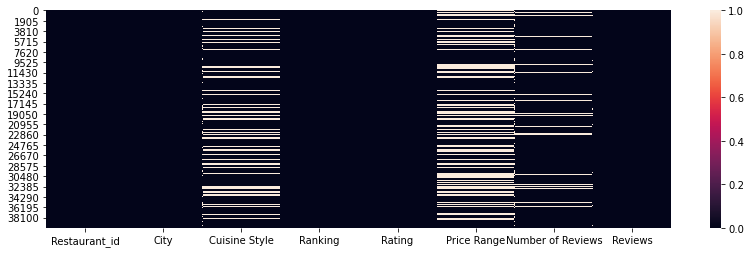

In [147]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(df.isnull())
print('отсутствует значений:', df.isnull().sum().sum(),
      '(', round(df.isnull().sum().sum()/4000), '%)')

Начальное значение - MAE: 0.43

# Приведение данных в нужный вид и будет задачей.

## Изучим значение 'Number of Reviews'

In [148]:
display(Check_data(df['Number of Reviews']))
# Создадим новый признак - пропущенное число обзоров - проверим в конце еще раз
df['Num_Review_NAN'] = pd.isna(df['Number of Reviews']).astype('uint8')


# заменим пропущенные значения средним по городу- City
city = df.City.unique()
city_reviews = {}
for i in city:
    city_reviews[i] = df[df.City == i]['Number of Reviews'].mean()

df['Number of Reviews'] = df[['City', 'Number of Reviews']].apply(
    lambda x: city_reviews[x[0]] if pd.isna(x[1]) else x[1], axis=1)
# MAE: 0.40856794166666666

Обзор даных для: Number of Reviews
2.0       1916
3.0       1636
4.0       1370
5.0       1181
6.0       1018
          ... 
2141.0       1
920.0        1
1404.0       1
979.0        1
1698.0       1
Name: Number of Reviews, Length: 1459, dtype: int64
count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64
пропущено значений: 2543


None

## Изучим значение 'Restaurant_id'

In [149]:
# посмотрим на признак 'Restaurant_id'
display(Check_data(df.Restaurant_id))

# видим, что есть сетевые рестораны и можно оформить новый признак - сетевой ресторан или нет(1-0),
# а также признак число ресторанов в сети

# создадим признак число ресторанов в сети
id = df.Restaurant_id.unique()
id_num = {}
for i in id:
    id_num[i] = df[df.Restaurant_id == i]['Restaurant_id'].count()
    
df['rest_netw_num'] = df[['Restaurant_id']].apply(lambda x: id_num[x[0]], axis=1)

# на основе этого признака создадим новый признак сетевой ресторан или нет(1-0)

df['rest_netw'] = df[['rest_netw_num']].apply(lambda x: 0 if x[0]==1 else 1, axis=1)

display(Check_data(df.rest_netw))

Обзор даных для: Restaurant_id
id_436      18
id_871      18
id_227      18
id_633      18
id_534      17
            ..
id_12042     1
id_13636     1
id_12509     1
id_7179      1
id_9767      1
Name: Restaurant_id, Length: 11909, dtype: int64
count      40000
unique     11909
top       id_436
freq          18
Name: Restaurant_id, dtype: object
пропущено значений: 0


None

Обзор даных для: rest_netw
1    35295
0     4705
Name: rest_netw, dtype: int64
count    40000.000000
mean         0.882375
std          0.322168
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: rest_netw, dtype: float64
пропущено значений: 0


None

## Изучим значение 'Price Range'

In [150]:
display(Check_data(df['Price Range']))
df['Price Range'].unique()

Обзор даных для: Price Range
$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64
count        26114
unique           3
top       $$ - $$$
freq         18412
Name: Price Range, dtype: object
пропущено значений: 13886


None

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [151]:
# создадим новый признак - пропущенные значения 'Price Range' 
df['Price_Range_NAN'] = pd.isna(df['Price Range']).astype('uint8')

Обзор даных для: Price
10.0    18412
30.0     6279
90.0     1423
Name: Price, dtype: int64
count    26114.000000
mean        19.168262
std         18.996918
min         10.000000
25%         10.000000
50%         10.000000
75%         30.000000
max         90.000000
Name: Price, dtype: float64
пропущено значений: 13886


None

Обзор даных для: Price_in_City
16.534653    5757
16.252808    4897
14.929215    3108
16.115582    2734
14.881671    2155
17.126113    2133
18.094321    2078
15.377685    1443
16.061538    1300
14.785592    1166
15.285451    1086
15.433962    1060
14.067439     949
15.711086     893
13.766816     892
13.658537     820
16.666667     816
16.134801     727
15.052006     673
15.827011     659
16.656051     628
17.449664     596
16.802974     538
17.719298     513
17.442827     481
17.042889     443
17.792208     385
14.840426     376
14.850498     301
14.476190     210
16.885246     183
Name: Price_in_City, dtype: int64
count    40000.000000
mean        15.985500
std          1.054124
min         13.658537
25%         15.052006
50%         16.134801
75%         16.534653
max         18.094321
Name: Price_in_City, dtype: float64
пропущено значений: 0


None

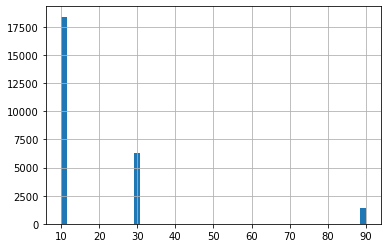

In [152]:
# перевести в число 10-30-900 основываясь на приблизительной оценке - большие цифры взяты чтобы работать с целыми числами
df['Price'] = df['Price Range'].replace(
    {'$$ - $$$': '10', '$': '30', '$$$$': '90'})
df['Price'] = pd.to_numeric(df['Price'])

# заполнить пропущенные значения на базе рейтинга, количества ревью и города?
# проанализируем Price
display(Check_data(df.Price))
df.Price.hist(bins=50)
# Вывод- цена 900 - скорее выброс и предлагаю заполнить пропущенные значения модой
p_mode=df.Price.mode()[0]
df['Price'].fillna(p_mode, inplace=True)
df['Price Range'] = df['Price Range'].fillna('$')
# MAE: 0.41655489424603176

# создадим новый признак - Средняя цена в городе
price_in_city_dict = df.groupby('City')['Price'].mean().to_dict()
df['Price_in_City'] = df['City'].map(price_in_city_dict)
# посмотрим что получилось
display(Check_data(df['Price_in_City']))

## Изучим значение 'Cuisine Style'

In [153]:
display(Check_data(df['Cuisine Style']))

Обзор даных для: Cuisine Style
['Italian']                                                                                                                    1032
['French']                                                                                                                      805
['Spanish']                                                                                                                     695
['French', 'European']                                                                                                          405
['Cafe']                                                                                                                        403
                                                                                                                               ... 
['Mediterranean', 'European', 'Portuguese', 'International', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']       1
['Japanese', 'Fusion', 'Healthy', 'Vegetarian

None

In [154]:
# создадим новый признак - пропущенный 'Cuisine Style'
df['Cuis_NAN'] = pd.isna(df['Cuisine Style']).astype('uint8')


In [155]:
# Заменим пропуски на Unknown
df['Cuisine Style'].fillna("'Unknown'", inplace=True)
# Выполним преобразование данных в колонке. Нам нужно получить список кухонь для каждого ресторана
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace('[','').replace(']','').replace(', ',',').split(','))

# Создадим признак, содержащий количество кухонь, представленных в ресторане

df['Cuisines_Number'] = df['Cuisine Style'].apply(lambda x: len(x))
MAE: 0.40795423730158725

In [156]:
# подсчитаем среднее значение кухонь в ресторанах
cuis_mean = df.Cuisines_Number.mean()
print(round(cuis_mean, 1))

# подсчет популярных кухонь
cuis_set = pd.Series(dtype='float64')

# определяем функцию счетчик


def cuis_num(cuis):
    for i in cuis:
        if i in cuis_set:
            cuis_set[i] += 1
        else:
            cuis_set[i] = 1
    return cuis_set


# считаем
df['Cuisine Style'].apply(cuis_num)
cuis_set.sort_values(ascending=False, inplace=True)
print(cuis_set.iloc[[0]])
print(len(cuis_set))
cuis_set
# нашли самую популярную кухню 'Vegetarian Friendly'
# заменим кухню 'Unknown' на самую популярную
df['Cuisine Style'] = df['Cuisine Style'].apply(
    lambda x: ["'Vegetarian Friendly'"] if x == ["'Unknown'"] else x)

# MAE: 0.3859641875

2.6
'Vegetarian Friendly'    11189
dtype: int64
126


## Изучим значение 'Reviews'

In [157]:
display(df.Reviews)

0                                    [['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]
1                                                [['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]
2                                                 [['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]
3                                                                                                                     [[], []]
4        [['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]
                                                                 ...                                                          
39995                 [['The real Italian experience!', 'Wonderful food, wonderful experience'], ['12/16/2017', '11/12/2017']]
39996                  [['Parisian atmosphere', 'Bit pricey but interesting decor and good...'], ['12/21/2017',

In [158]:
# найдем и преобразуем даты в Reviews
pattern=re.compile('\d+[/]\d+[/]\d+')
df['rev_date']=df['Reviews'].apply(lambda x: pattern.findall(x))
df['rev_date']=df['rev_date'].apply(lambda x: [pd.to_datetime(i).date() for i in x])


# создадим столбец число реальных отзывов
df['date_num'] = df.rev_date.apply(lambda x: len(x))
display(Check_data(df.date_num))
display(df.rev_date)
display(Check_data(df.rev_date))

Обзор даных для: date_num
2    28971
0     6471
1     4556
3        2
Name: date_num, dtype: int64
count    40000.000000
mean         1.562600
std          0.754815
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: date_num, dtype: float64
пропущено значений: 0


None

0        [2017-12-31, 2017-11-20]
1        [2017-07-06, 2016-06-19]
2        [2018-01-08, 2018-01-06]
3                              []
4        [2017-11-18, 2017-02-19]
                   ...           
39995    [2017-12-16, 2017-11-12]
39996    [2017-12-21, 2017-12-12]
39997    [2016-11-03, 2008-04-12]
39998    [2017-07-11, 2017-06-18]
39999    [2016-01-31, 2012-07-04]
Name: rev_date, Length: 40000, dtype: object

Обзор даных для: rev_date
[]                          6471
[2018-01-07, 2018-01-06]      46
[2018-01-08, 2018-01-07]      40
[2018-01-07, 2018-01-07]      36
[2018-01-07, 2018-01-05]      36
                            ... 
[2017-10-01, 2017-09-05]       1
[2017-08-04, 2017-01-28]       1
[2016-12-25, 2015-03-30]       1
[2017-11-20, 2017-03-25]       1
[2017-03-22, 2017-03-19]       1
Name: rev_date, Length: 24606, dtype: int64
count     40000
unique    24606
top          []
freq       6471
Name: rev_date, dtype: object
пропущено значений: 0


None

In [159]:
# Считываем текущее число
today = datetime.today().date()


def to_date_max(dates):
    # переводим каждую строку из dates в формат datetime и сохраняем в виде Series
    dates = pd.Series(dates)
    return dates.max()  # возвращаем max из Series

def to_date_min(dates):
    dates = pd.Series(dates)
    return dates.min()

# применяем to_date_max к df['rev_date'] и сохраняем в df['max']
df['date_max'] = df.rev_date.apply(to_date_max)

df['date_min'] = df.rev_date.apply(to_date_min)

# создадим поле в днях между отзывами 
df['date_diff'] = (df.date_max-df.date_min).apply(lambda x: x.days)

# удалим пропуски средним значением между отзывами
df.date_diff = df.date_diff.fillna(df.date_diff.mean())

<ipython-input-159-866cd4013f55>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dates = pd.Series(dates)
<ipython-input-159-866cd4013f55>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dates = pd.Series(dates)


In [160]:
df.date_diff.max()

3207.0

In [161]:
# создадим поле в днях самого свежего отзыва от текущей даты
df['date_rev_today'] = (today-df.date_max).apply(lambda x: x.days)
# удалим пропуски средним значением между
df.date_rev_today = df.date_rev_today.fillna(df.date_rev_today.mean())

In [162]:
# display(df.date_max.value_counts())
'''
display(type(df.date_max[0]))
display(df.date_max[0])

display(Check_data(df.date_max))

df.date_max = pd.to_datetime(df.date_max)
df.date_max.max()
'''

'\ndisplay(type(df.date_max[0]))\ndisplay(df.date_max[0])\n\ndisplay(Check_data(df.date_max))\n\ndf.date_max = pd.to_datetime(df.date_max)\ndf.date_max.max()\n'

## Изучим параметр 'City'

In [163]:
display(Check_data(df.City))

Обзор даных для: City
London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64
count      40000
unique        31
top       London
freq        5757
Name: City, dtype: object
пропущено значений: 0


None

<AxesSubplot:>

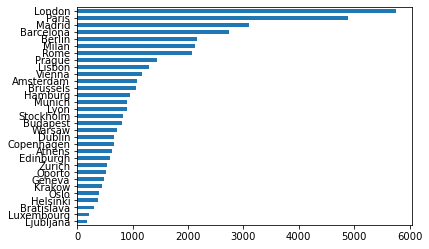

In [164]:
df['City'].value_counts(ascending=True).plot(kind='barh')

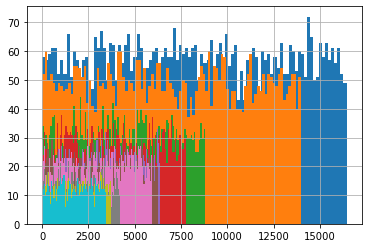

In [165]:
# посмотрим на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [166]:
# создадим признак - число ресторанов в городе
city = df.City.unique()
city_rest = {}
for i in city:
    city_rest[i] = df[df.City == i]['City'].count()

df['city_rest_num'] = df['City'].apply(lambda x: city_rest[x])


## Изучим Ranking

<AxesSubplot:>

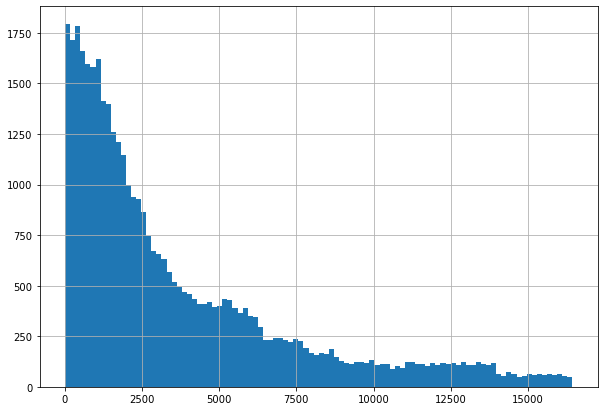

In [167]:
plt.rcParams['figure.figsize'] = (10,7)
df['Ranking'].hist(bins=100)

In [168]:
display(Check_data(df.Ranking))

Обзор даных для: Ranking
1080.0     19
437.0      18
491.0      18
345.0      18
431.0      18
           ..
14711.0     1
9409.0      1
14109.0     1
10501.0     1
5699.0      1
Name: Ranking, Length: 11936, dtype: int64
count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64
пропущено значений: 0


None

In [169]:
# Ranking зависит от размера города и в общем случае от числа ресторанов в нем
# получим среднее значение от числа ресторанов в городе
df['Ranking_rest_num'] = df.apply(
    lambda x: x['Ranking']/x['city_rest_num'], axis=1)

Обзор даных для: Ranking_rest_num
1.000000    14
0.500000     6
2.000000     6
2.500000     5
2.666667     5
            ..
2.289264     1
1.728361     1
2.353846     1
2.204620     1
0.180476     1
Name: Ranking_rest_num, Length: 39557, dtype: int64
count    40000.000000
mean         1.445413
std          0.834555
min          0.000174
25%          0.723119
50%          1.439623
75%          2.166667
max          3.094065
Name: Ranking_rest_num, dtype: float64
пропущено значений: 0


None

<AxesSubplot:>

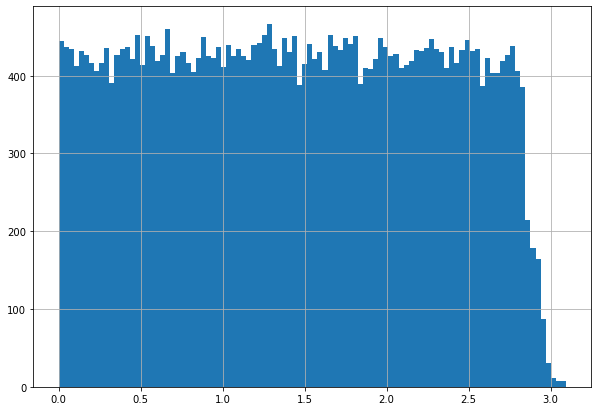

In [170]:
display(Check_data(df.Ranking_rest_num))
plt.rcParams['figure.figsize'] = (10,7)
df['Ranking_rest_num'].hist(bins=100)

# EDA Exploratory Data Analysis

EDA Exploratory Data Analysis - Анализ данных На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками. В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой. Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

,Ranking,Rating,Number of Reviews,Num_Review_NAN,rest_netw_num,rest_netw,Price_Range_NAN,Price,Price_in_City,Cuis_NAN,Cuisines_Number,date_num,date_diff,date_rev_today,city_rest_num,Ranking_rest_num
Ranking,1.000000,-0.368371,-0.210819,0.094078,-0.762958,-0.675937,0.233043,-0.088603,0.152622,0.147995,-0.320250,-0.139749,0.092227,0.179795,0.709115,0.553154
Rating,-0.368371,1.000000,0.029263,0.008386,0.285959,0.223689,-0.064567,0.085755,0.044329,-0.038263,0.120059,0.020524,-0.073525,-0.083557,-0.061376,-0.542702
Number of Reviews,-0.210819,0.029263,1.000000,-0.009163,0.243495,0.096649,-0.242483,0.136468,0.127499,-0.184967,0.390491,0.175413,-0.133822,-0.186434,0.028369,-0.387356
Num_Review_NAN,0.094078,0.008386,-0.009163,1.000000,-0.095068,-0.054665,0.266923,-0.059464,-0.039309,0.186118,-0.175335,-0.410995,-0.061371,0.107658,-0.023637,0.207244
rest_netw_num,-0.762958,0.285959,0.243495,-0.095068,1.000000,0.480278,-0.242159,0.104574,-0.104293,-0.164252,0.349713,0.225233,-0.097878,-0.192528,-0.591366,-0.527633
rest_netw,-0.675937,0.223689,0.096649,-0.054665,0.480278,1.000000,-0.120078,0.039690,-0.110659,-0.070235,0.162240,0.025808,-0.051183,-0.090786,-0.468096,-0.306396
Price_Range_NAN,0.233043,-0.064567,-0.242483,0.266923,-0.242159,-0.120078,1.000000,-0.273518,-0.122442,0.753881,-0.566692,-0.506996,0.090532,0.289489,-0.043922,0.463445
Price,-0.088603,0.085755,0.136468,-0.059464,0.104574,0.039690,-0.273518,1.000000,0.066057,-0.206200,0.148871,0.125328,-0.034516,-0.069809,0.014376,-0.174572
Price_in_City,0.152622,0.044329,0.127499,-0.039309,-0.104293,-0.110659,-0.122442,0.066057,1.000000,-0.111756,0.129950,0.089197,-0.036554,-0.053399,0.217637,-0.012636
Cuis_NAN,0.147995,-0.038263,-0.184967,0.186118,-0.164252,-0.070235,0.753881,-0.206200,-0.111756,1.000000,-0.490787,-0.345494,0.049462,0.153149,-0.046676,0.323129


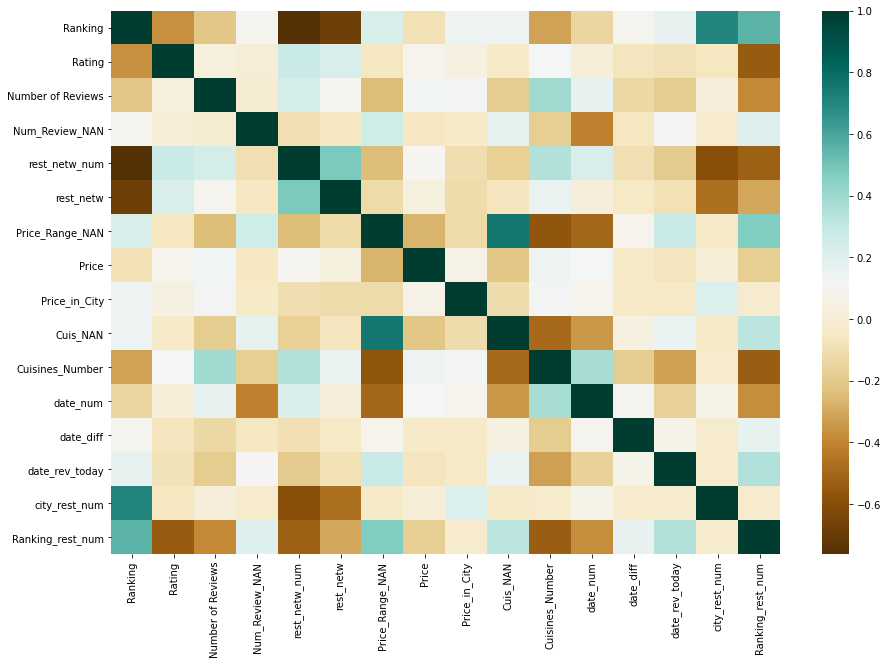

In [171]:
# MAE: 0.20876999999999998

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr(),cmap="BrBG")
df.corr()

In [172]:
df['Restaurant_id'] = df['Restaurant_id'].apply(
    lambda x: x.split('_')[1]).astype(int)

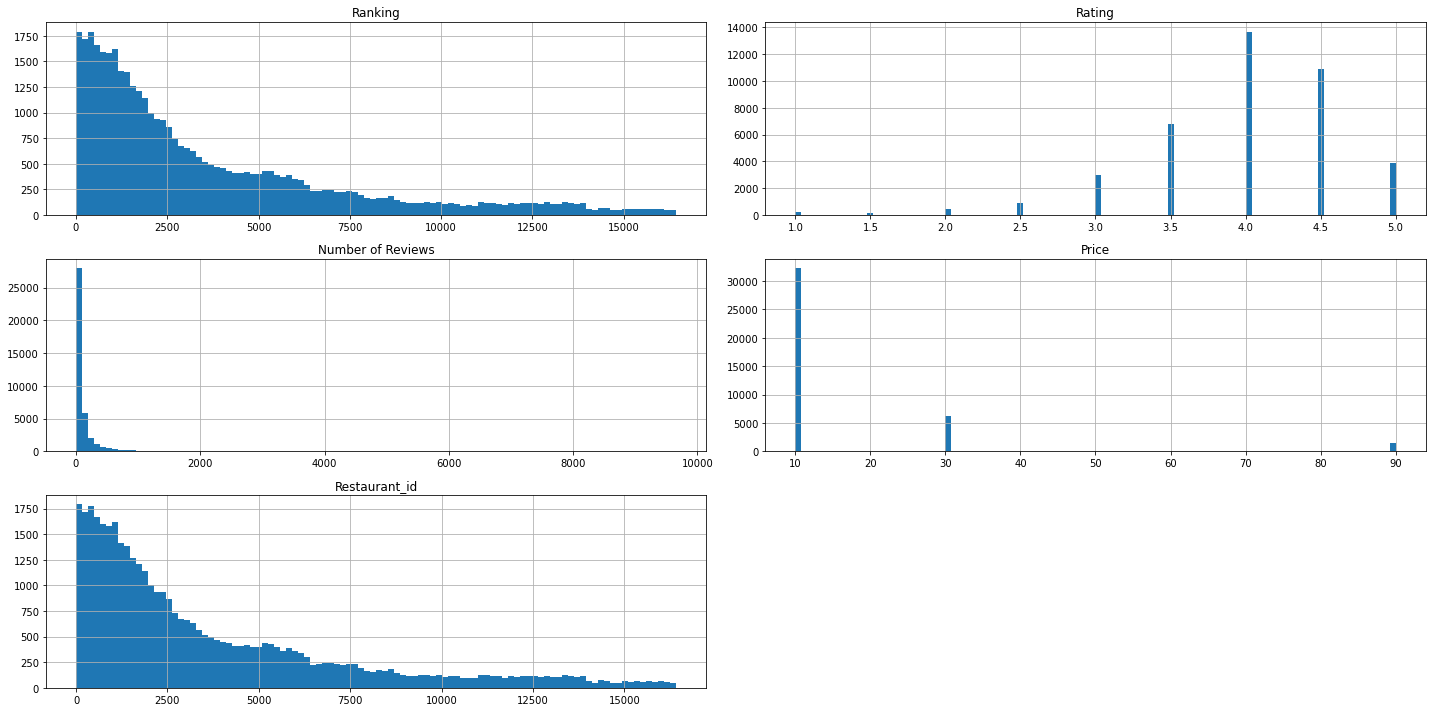

In [173]:
df[['Ranking', 'Rating', 'Number of Reviews','Price', 'Restaurant_id']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()

# FE создаем дамми переменные

## создаем дамми переменные

In [174]:
# сделать 31 dummy параметр по City
df = pd.get_dummies(df, columns=['City', ], dummy_na=True)
# MAE: 0.22007100000000002

In [175]:
# создадим подобие dummy признаков для кухонь
cuisines = set()

for row in df['Cuisine Style']:
    for cuisine in row:
        cuisines.add(cuisine)

# Затем создаем колонки для каждой кухни

def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in cuisines:
    df[item] = df['Cuisine Style'].apply(find_item)

In [176]:
# создадим также дамми данные по 'Price Range'
df = pd.get_dummies(df, columns=['Price Range'])

df = df.rename(columns={'Price Range_$': 'Price_Range_1', 'Price Range_$$ - $$$': 'Price_Range_2',
                            'Price Range_$$$$': 'Price_Range_3'})

## Полиномиальные признаки

In [177]:
pf = PolynomialFeatures(2, interaction_only=True)
poly_features = pf.fit_transform(df[['Ranking', 'rest_netw_num','rest_netw']])
poly_features.shape

(40000, 7)

In [178]:
poly_features
scaler = StandardScaler()
poly_features=scaler.fit_transform(poly_features)
display(poly_features)
df[['pf1', 'pf2','pf3','pf4','pf5','pf6','pf7']] = pd.DataFrame(poly_features)

array([[ 0.        ,  0.51068294, -0.83177923, ...,  0.77386895,
         1.18985439, -0.77268511],
       [ 0.        , -0.57675915,  0.86101622, ...,  0.55504288,
        -0.3413244 ,  0.85552617],
       [ 0.        , -0.89600821,  0.37736038, ..., -1.49375706,
        -0.79084478,  0.39032295],
       ...,
       [ 0.        , -0.54575101,  0.86101622, ...,  0.74284137,
        -0.29766322,  0.85552617],
       [ 0.        , -0.81835303,  0.37736038, ..., -1.11750686,
        -0.68150199,  0.39032295],
       [ 0.        ,  0.31034338, -0.58995131, ...,  1.19813025,
         0.90776517, -0.5400835 ]])

In [179]:
display(Check_data(df.pf1))
# удалим 'ненужный' признак
df.drop('pf1', axis=1, inplace=True)

Обзор даных для: pf1
0.0    40000
Name: pf1, dtype: int64
count    40000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: pf1, dtype: float64
пропущено значений: 0


None

# Применим и сформируем итоговый DF для модели

In [180]:
# удаляем колонки - object
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis=1, inplace=True)

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 183 entries, Restaurant_id to pf7
dtypes: float64(14), int32(1), int64(130), uint8(38)
memory usage: 45.5 MB


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [182]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [183]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [184]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [185]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20503799999999997


In [187]:
#Вычисляем коэффициент детерминации:
R_2 = metrics.r2_score(y_test, y_pred)
print(R_2)

0.8003003781708331


<AxesSubplot:>

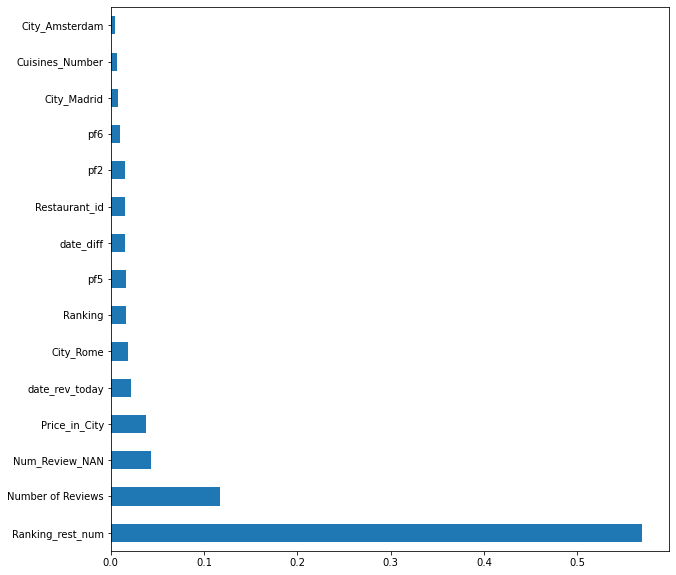

In [186]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')